In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch.nn.functional as F
import torch.nn.init as init
import shap

In [2]:
with open('data/merged_data.csv') as x:
    ncols = len(x.readline().split(','))
merged_data = pd.read_csv('data/merged_data.csv', usecols=range(1,ncols))

In [3]:
merged_data

,year,round,name,grid,positionOrder,points,laps,milliseconds,fastestLap,rank,...,position_qualifying,points_constructorResults,points_constructorStandings,position_constructorStandings,wins,month_sin,month_cos,day_sin,day_cos,day_of_week_sin
0,2009,1,3.0,1.0,1,10.0,58.0,5655784.0,17.0,3.0,...,1.0,18.0,18.0,1.0,1.0,1.000000,6.123234e-17,-0.394356,0.918958,-0.781832
1,2009,1,3.0,1.0,1,10.0,58.0,5655784.0,17.0,3.0,...,1.0,18.0,25.0,1.0,2.0,1.000000,6.123234e-17,-0.394356,0.918958,-0.781832
2,2009,1,3.0,1.0,1,10.0,58.0,5655784.0,17.0,3.0,...,1.0,18.0,36.0,1.0,2.0,1.000000,6.123234e-17,-0.394356,0.918958,-0.781832
3,2009,1,3.0,1.0,1,10.0,58.0,5655784.0,17.0,3.0,...,1.0,18.0,50.0,1.0,3.0,1.000000,6.123234e-17,-0.394356,0.918958,-0.781832
4,2009,1,3.0,1.0,1,10.0,58.0,5655784.0,17.0,3.0,...,1.0,18.0,68.0,1.0,4.0,1.000000,6.123234e-17,-0.394356,0.918958,-0.781832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9523628,2023,18,52.0,35.0,40,0.0,0.0,15090541.0,-1.0,25.0,...,-1.0,0.0,0.0,23.0,0.0,-0.866025,5.000000e-01,-0.968077,-0.250653,-0.781832
9523629,2023,19,31.0,35.0,40,0.0,0.0,15090541.0,-1.0,25.0,...,-1.0,0.0,0.0,23.0,0.0,-0.866025,5.000000e-01,-0.394356,0.918958,-0.781832
9523630,2023,20,49.0,35.0,40,0.0,0.0,15090541.0,-1.0,25.0,...,-1.0,0.0,0.0,23.0,0.0,-0.500000,8.660254e-01,0.848644,0.528964,-0.781832
9523631,2023,21,27.0,35.0,40,0.0,0.0,15090541.0,-1.0,25.0,...,-1.0,0.0,0.0,23.0,0.0,-0.500000,8.660254e-01,-0.651373,-0.758758,-0.781832


#### Data Preparing

In [4]:
X = merged_data.drop(['positionOrder'], axis=1)
y = merged_data['positionOrder']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.005, random_state=42)

# Normalize X
scaler = StandardScaler()
features_to_scale = X_train.columns.difference(['year', 'round'])
X_to_scale = X_train[features_to_scale]
X_train_scaled = scaler.fit_transform(X_to_scale)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features_to_scale)
X_train_scaled[['year', 'round']] = X_train[['year', 'round']].reset_index(drop=True)

X_test_scaled = scaler.transform(X_test[features_to_scale])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features_to_scale)
X_test_scaled[['year', 'round']] = X_test[['year', 'round']].reset_index(drop=True)

# Convert to tensors
X_train = torch.tensor(X_train_scaled.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader for batch processing
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

In [5]:
len(X_train)

9476014

In [6]:
len(X_test)

47619

In [7]:
len(train_loader)

74032

#### Model Definition

In [9]:
class FNN(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 32)
        self.fc8 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = torch.relu(self.fc7(x))
        return self.fc8(x)

def apply_xavier(model):
    for module in model.modules():
        if isinstance(module, nn.Linear):
            init.xavier_uniform_(module.weight)

fnn_model = FNN(input_dim=X_train.shape[1])
print(fnn_model)
apply_xavier(fnn_model)

# Training Loop
#def train(model, epochs=20, lr=0.001, l2_factor=0.001):
def train(model, epochs=30, lr=0.001):
    criterion = nn.MSELoss()
    #optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_factor)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_epoch_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} Loss: {avg_epoch_loss}")

FNN(
  (fc1): Linear(in_features=30, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=64, bias=True)
  (fc7): Linear(in_features=64, out_features=32, bias=True)
  (fc8): Linear(in_features=32, out_features=1, bias=True)
)


In [10]:
# Train the FNN
train(fnn_model)

Epoch 1/30 Loss: 5.5433763304738575
Epoch 2/30 Loss: 3.0008890021657595
Epoch 3/30 Loss: 2.159708512860413
Epoch 4/30 Loss: 1.7298337242827513
Epoch 5/30 Loss: 1.446596418943571
Epoch 6/30 Loss: 1.2489477099715112
Epoch 7/30 Loss: 1.1150749374904836
Epoch 8/30 Loss: 1.040074762513268
Epoch 9/30 Loss: 0.9663581338972546
Epoch 10/30 Loss: 0.8963087217985733
Epoch 11/30 Loss: 0.8682719627089327
Epoch 12/30 Loss: 0.8344424625646113
Epoch 13/30 Loss: 0.763068484075799
Epoch 14/30 Loss: 0.7410812358928855
Epoch 15/30 Loss: 0.7516396698184264
Epoch 16/30 Loss: 0.657510053484574
Epoch 17/30 Loss: 0.6371490794061079
Epoch 18/30 Loss: 0.6092538627483287
Epoch 19/30 Loss: 0.5993467440280394
Epoch 20/30 Loss: 0.6198741341632094
Epoch 21/30 Loss: 0.5753963034524942
Epoch 22/30 Loss: 0.5449572214463242
Epoch 23/30 Loss: 0.5495032773274459
Epoch 24/30 Loss: 0.521899814455405
Epoch 25/30 Loss: 0.5100554992448436
Epoch 26/30 Loss: 0.5100732462834716
Epoch 27/30 Loss: 0.5025748259523574
Epoch 28/30 Loss

In [11]:
# Save the FNN model's state dictionary
torch.save(fnn_model.state_dict(), 'fnn_model.pth')

In [8]:
fnn_model = FNN(input_dim=X_train.shape[1])
fnn_model.load_state_dict(torch.load('fnn_model.pth'))

<All keys matched successfully>

In [14]:
def compute_rmse(y_pred, y_true):
    return torch.sqrt(torch.mean((y_pred - y_true)**2))

# Predict on the test set
fnn_model.eval()
with torch.no_grad():
    predictions = fnn_model(X_test)

rmse = compute_rmse(predictions.squeeze(), y_test)
print(f"FNN Model RMSE: {rmse.item()}")

FNN Model RMSE: 0.6238806247711182


#### Model Interpretation
SHAP (SHapley Additive exPlanations) is a game theory-based approach for explaining the output of ML or deep learning models. SHAP values provide insights into the impact of each feature in a prediction model, and they are grounded in the theory of Shapley values from cooperative game theory.
Below are some of the key plots provided by the SHAP library:
1. Summary Plot: This plot shows the effects of all the features on the model's output. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value.
2. Dependence Plot: This plot shows the effect of a single feature across the whole dataset. It plots the SHAP value of a feature for every instance and typically colors points by the value of another feature. It's useful for seeing interactions between features.
3. Bar Plot: This shows the mean absolute SHAP values for each feature. Unlike the summary plot, it only gives an aggregated view of the importance of each feature without showing the distribution.
4. Interaction Plot: This plot is an extension of the dependence plot and it includes an interaction effect. It shows how the SHAP value for a particular feature changes as another feature changes.

In [41]:
# Using a part of training data for creating background distribution for shap
background = shap.utils.sample(X_train, 100)
X_test_numpy = X_test.numpy()
fnn_model.eval()

# Define a wrapper function for the model's prediction
def fnn_predict(data_as_numpy):
    data_as_tensor = torch.from_numpy(data_as_numpy).float()
    with torch.no_grad():
        predictions = fnn_model(data_as_tensor)
    return predictions.numpy()

# Initialize the SHAP explainer with the background data and the prediction function
fnn_explainer = shap.KernelExplainer(model=fnn_predict, data=background.numpy())

# Calculate SHAP values for the test dataset
fnn_shap_values = fnn_explainer.shap_values(X=X_test_numpy[:50])

  0%|          | 0/50 [00:00<?, ?it/s]

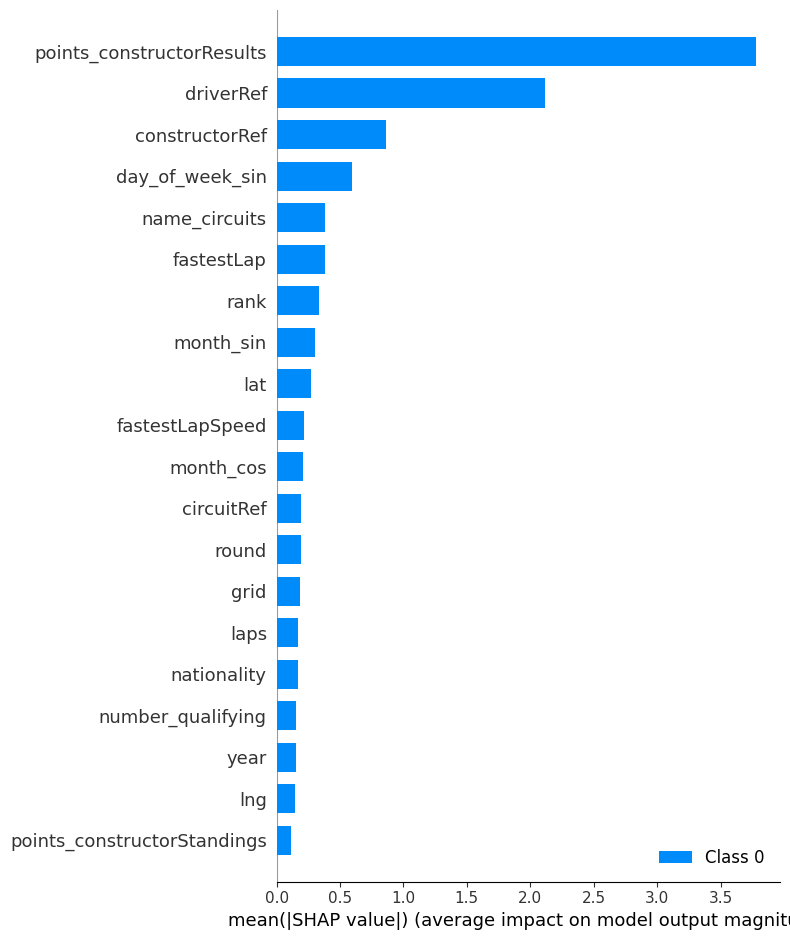

In [46]:
# Summary plot
shap.summary_plot(fnn_shap_values, X_test_numpy[:50], feature_names=X.columns)

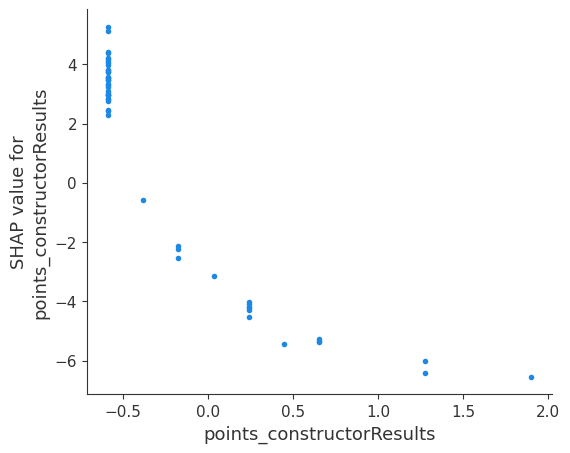

In [60]:
# Dependence plot for single feature points_constructorResults, which has major contribution to the predictions
shap.dependence_plot('points_constructorResults', fnn_shap_values[0], X_test_numpy[:50], feature_names=X.columns, interaction_index=None)

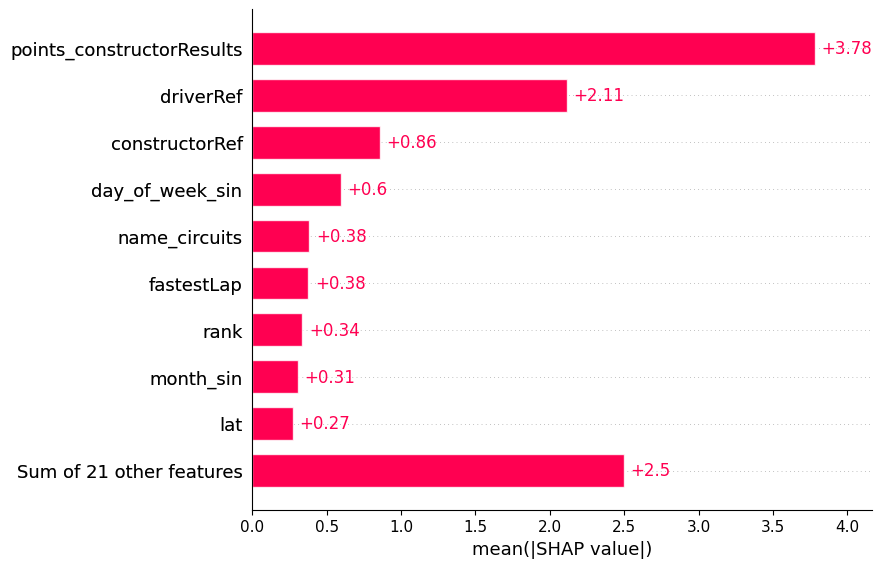

In [57]:
# Bar plot - creating an Explanation object from the SHAP values
shap_values = np.array(fnn_shap_values[0])
expl = shap.Explanation(values=shap_values, data=X_test_numpy[:50], feature_names=X.columns)
shap.plots.bar(expl)

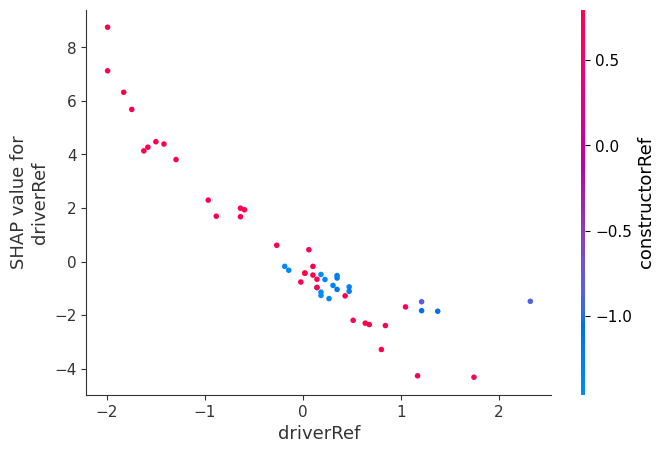

In [67]:
# Interaction plot - between features constructorRef and driverRef
shap.dependence_plot('driverRef', fnn_shap_values[0], X_test_numpy[:50], feature_names=X.columns, interaction_index='constructorRef')